# Logistic regression baseline
Another strong baseline to evaluate is logistic regression

In [1]:
import importlib; import cours_proj4_funcs; 
importlib.reload(cours_proj4_funcs)
from cours_proj4_funcs import f_read_npzF, f_addIdxFeat, f_fileApp

In [2]:
import numpy as np
import os

X_tr_ini, y_tr_ini, X_data_tr, fnames_tr, y_cat_tr = f_read_npzF(os.path.join('data', 'data_train.npz'))
X_tr_ini1 = f_addIdxFeat(X_tr_ini)

X_va_ini, y_va_ini, X_data_va, fnames_va, y_cat_va = f_read_npzF(os.path.join('data', 'data_valid.npz'))
X_va_ini1 = f_addIdxFeat(X_va_ini)

X_te_ini, y_te_ini, X_data_te, fnames_te, y_cat_te = f_read_npzF(os.path.join('data', 'data_test.npz'))
X_te_ini1 = f_addIdxFeat(X_te_ini)

#### - Evaluate the logistic regression baseline

In [3]:
from sklearn.model_selection import train_test_split

# Split into train/test sets.. Again, here using only TRAIN data set
X_tr, X_te, y_tr, y_te = train_test_split(X_tr_ini, y_tr_ini, test_size=60, random_state=0)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator
logreg = make_pipeline(StandardScaler()
                       ,LogisticRegression(solver='liblinear') )

# Fit it to train data
logreg.fit(X_tr, y_tr);

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Split Test accuracy: {:.3f}'.format(accuracy)) # 1.000

/home/wilfredo/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Split Test accuracy: 0.967


#### - Tune its regularization strength parameter with cross-validated grid-search
>**Note**<br>Running a cross-validation on top of a grid search can computationally be very demanding. Under certain conditions, this might lead to a "never ending" model fit. We recommend that you use `GridSearchCV` together with `verbose=1` to better understand how the computation is progressing. Also, if your computer provides parallel computation, you can use `n_jobs=2` (or `4`, `8` or `-1`) to specify how many parallel computation you want to allow.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

# Logistic regression estimator
logreg_estimator = Pipeline([ ('preprocessor', None) #preprocessor) # No OneHotEncoder
                             ,('scaler', StandardScaler()) # due to standardization and solvers sensitive to rescaling
                             ,('logreg', LogisticRegression())
                            ])

# Grid search with cross-validation
Cs = np.logspace(-4, 4, num=10) #20) #10

grids = [ { 'logreg__multi_class': ['ovr']
            ,'logreg__solver': ['liblinear']
            ,'logreg__C': Cs}
          ,{'logreg__multi_class': ['multinomial']
            ,'logreg__solver': ['saga']
            ,'logreg__C': Cs }
        ]

logreg_gscv = GridSearchCV( logreg_estimator
                           ,grids
                           ,cv=10 #k #picked randomly
                           ,refit=True
                           ,return_train_score=True
                           ,verbose=1
                           ,n_jobs=-1 #4
                           )

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Fit/evaluate estimator
logreg_gscv.fit(X_tr_ini, y_tr_ini)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished
/home/wilfredo/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', None), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'logreg__multi_class': ['ovr'], 'logreg__solver': ['liblinear'], 'logreg__C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])}, {'logreg__multi_class': ['multinomial'], 'logreg__solver': ['saga'], 'logreg__C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])}],
 

In [7]:
import pandas as pd
# Collect results in a DataFrame
logreg_results = pd.DataFrame({ 'strategy': logreg_gscv.cv_results_['param_logreg__multi_class']
                                ,'C': logreg_gscv.cv_results_['param_logreg__C']
                                ,'mean_tr': logreg_gscv.cv_results_['mean_train_score']
                                ,'mean_te': logreg_gscv.cv_results_['mean_test_score']
                                ,'std_te': logreg_gscv.cv_results_['std_test_score']
                                ,'solver': logreg_gscv.cv_results_['param_logreg__solver']
                                })

# Ten best combinations according to the mean test score
logreg_results.sort_values(by='mean_te', ascending=False).head(10)

,strategy,C,mean_tr,mean_te,std_te,solver
8,ovr,1291.55,1.000000,0.914286,0.045786,liblinear
9,ovr,10000,1.000000,0.907143,0.052550,liblinear
16,multinomial,21.5443,1.000000,0.900000,0.042162,saga
12,multinomial,0.00599484,1.000000,0.900000,0.052428,saga
11,multinomial,0.000774264,0.975027,0.900000,0.049260,saga
18,multinomial,1291.55,1.000000,0.900000,0.049209,saga
17,multinomial,166.81,1.000000,0.900000,0.038086,saga
7,ovr,166.81,1.000000,0.896429,0.045273,liblinear
6,ovr,21.5443,1.000000,0.896429,0.057157,liblinear
13,multinomial,0.0464159,1.000000,0.896429,0.042800,saga


The logistic regression accuracy is around 92% ± 4% (std) according to the validation accuracy

In [8]:
# Report test score
print('Test accuracy: {:.2f}%'.format(100*logreg_gscv.score(X_va_ini, y_va_ini)))

Test accuracy: 91.37%


In [9]:
test_acc_lreg = logreg_gscv.score(X_te_ini, y_te_ini)
print("Decision tree test accuracy: {}".format(test_acc_lreg))

# Decision tree accuracy to append into the file 
f_fileApp('data/results09.csv',2,"logistic", test_acc_lreg)

Decision tree test accuracy: 0.98


#### - Pick ten images and compute the probability for each class using the `predict_proba()` function of your estimator. Plot the results for each image and comment your findings. For example, you can plot the ten images in subplots and collect the probabilities in a DataFrame.

<img src="https://d7whxh71cqykp.cloudfront.net/uploads/image/data/4251/predict-proba.png" alt="Smiley face" height="90%" width="90%">

In [10]:
#Picking ten images with the best C 

idx_mean_te = logreg_results["mean_te"].idxmax() # index of the Max mean_te

# Create the estimator
logreg2 = make_pipeline(StandardScaler()
                       ,LogisticRegression( C = logreg_results["C"][idx_mean_te ]
                                           ,multi_class = logreg_results["strategy"][idx_mean_te ]#'ovr'
                                           ,solver = logreg_results["solver"][idx_mean_te ]) )

# Fit it to train data
logreg2.fit(X_tr_ini, y_tr_ini);

# Accuracy on test set
accuracy = logreg2.score(X_va_ini, y_va_ini)
print('Validation accuracy: {:.3f}'.format(accuracy)) # 1.000

Validation accuracy: 0.914


In [11]:
aimgs = ["bike/bike-0067.png","bike/bike-0068.png","bike/bike-0069.png"
         ,"bike/bike-0070.png","bike/bike-0071.png","bike/bike-0072.png"
         ,"car/car-0068.png","car/car-0069.png","car/car-0070.png","car/car-0071.png"]

# Gettting the index numbers from the image array above 
idx_imgs = []
for i, b in enumerate(np.isin(fnames_va, aimgs)):
    if b: idx_imgs.append(i)

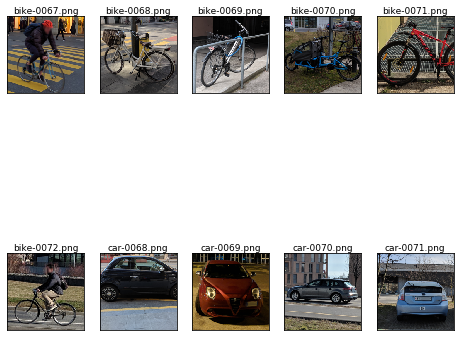

In [12]:
gs_results = []

%matplotlib inline 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 8))

for i, axis in enumerate(axes.flatten()):
    
    if i >= len(aimgs):
        axis.axis("off")
        continue
    
    img = X_data_va[idx_imgs[i]] # img_batches_va[ idx_imgs[i] ]
    
    axis.imshow(img)
    
    axis.set_title(aimgs[i].split('/')[1], size=9, pad=2)
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis
    
    gs_results.append({ "img_name" : aimgs[i].split('/')[1]
                       ,"predict_proba" : logreg2.predict_proba( [ X_va_ini[idx_imgs[i]] ] )[0] #np size(1,6)
                      })
    
plt.show()

In [13]:
feat_catName = [cat_name.split(':')[1] for cat_name in y_cat_va ]

gs_results_df = pd.DataFrame(gs_results)

pd.DataFrame(gs_results_df["predict_proba"].values.tolist(), columns=feat_catName, index=gs_results_df["img_name"]).round(2)

,bike,car,motorcycle,other,truck,van
img_name,,,,,,
bike-0067.png,0.42,0.00,0.00,0.42,0.0,0.16
bike-0068.png,1.00,0.00,0.00,0.00,0.0,0.00
bike-0069.png,1.00,0.00,0.00,0.00,0.0,0.00
bike-0070.png,1.00,0.00,0.00,0.00,0.0,0.00
bike-0071.png,0.99,0.00,0.01,0.00,0.0,0.00
bike-0072.png,1.00,0.00,0.00,0.00,0.0,0.00
car-0068.png,0.00,1.00,0.00,0.00,0.0,0.00
car-0069.png,0.00,0.99,0.00,0.00,0.0,0.01
car-0070.png,0.00,1.00,0.00,0.00,0.0,0.00


Finally, vary the regularization strength of your estimator. What is the effect on the probabilities? Write your observations in a markdown cell.

In [14]:
#Change C=10000
# Create the estimator
logreg3 = make_pipeline(StandardScaler()
                       ,LogisticRegression( C=21.5443
                                           ,multi_class='ovr'
                                           ,solver='liblinear' ) )

# Fit it to train data
logreg3.fit(X_tr_ini, y_tr_ini);

# Accuracy on test set
accuracy = logreg3.score(X_va_ini, y_va_ini)
print('Validation accuracy: {:.3f}'.format(accuracy)) # 1.000

Validation accuracy: 0.921


In [15]:
gs_results = []

for i in range(len(aimgs)+1):
    
    if i >= len(aimgs): continue
    
    gs_results.append({ "img_name" : aimgs[i].split('/')[1]
                       ,"predict_proba" : logreg3.predict_proba( [ X_va_ini[idx_imgs[i]] ] )[0] #np size(1,6)
                      })


#feat_catName = [cat_name.split(':')[1] for cat_name in y_cat_va ]

gs_results_df = pd.DataFrame(gs_results)

pd.DataFrame(gs_results_df["predict_proba"].values.tolist(), columns=feat_catName, index=gs_results_df["img_name"]).round(2)

,bike,car,motorcycle,other,truck,van
img_name,,,,,,
bike-0067.png,0.46,0.00,0.00,0.46,0.0,0.09
bike-0068.png,0.97,0.00,0.00,0.00,0.0,0.03
bike-0069.png,0.99,0.00,0.00,0.00,0.0,0.00
bike-0070.png,0.99,0.00,0.01,0.00,0.0,0.00
bike-0071.png,0.99,0.00,0.00,0.01,0.0,0.00
bike-0072.png,0.99,0.00,0.00,0.00,0.0,0.00
car-0068.png,0.00,0.98,0.00,0.00,0.0,0.02
car-0069.png,0.00,0.94,0.00,0.01,0.0,0.05
car-0070.png,0.00,0.99,0.01,0.00,0.0,0.00


The probabilities slightly decrease in categorizing the images